In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import anderson_ksamp
import mlflow
import torch
from torch import nn, optim
import torch.utils.data as data_utils
from IPython.display import clear_output
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import Callback
import yaml

from genhack.dataset import StationsDataset
from genhack.models import models
from genhack.utils import *
from run import run

In [19]:
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlflow.db'

In [20]:
df_all = pd.read_csv('data/df_all.csv')
df_all['dates'] = pd.to_datetime(df_all['dates'])
df_all = df_all.set_index('dates').sort_index()

df_train = pd.read_csv('data/df_train.csv')
df_train['dates'] = pd.to_datetime(df_train['dates'])
df_train = df_train.set_index('dates').sort_index()

df_test = pd.read_csv('data/df_test.csv')
df_test['dates'] = pd.to_datetime(df_test['dates'])
df_test = df_test.set_index('dates').sort_index()

In [21]:
#train + val (1981-2002) | test (2002-2007) | test genhack (2007-2016)

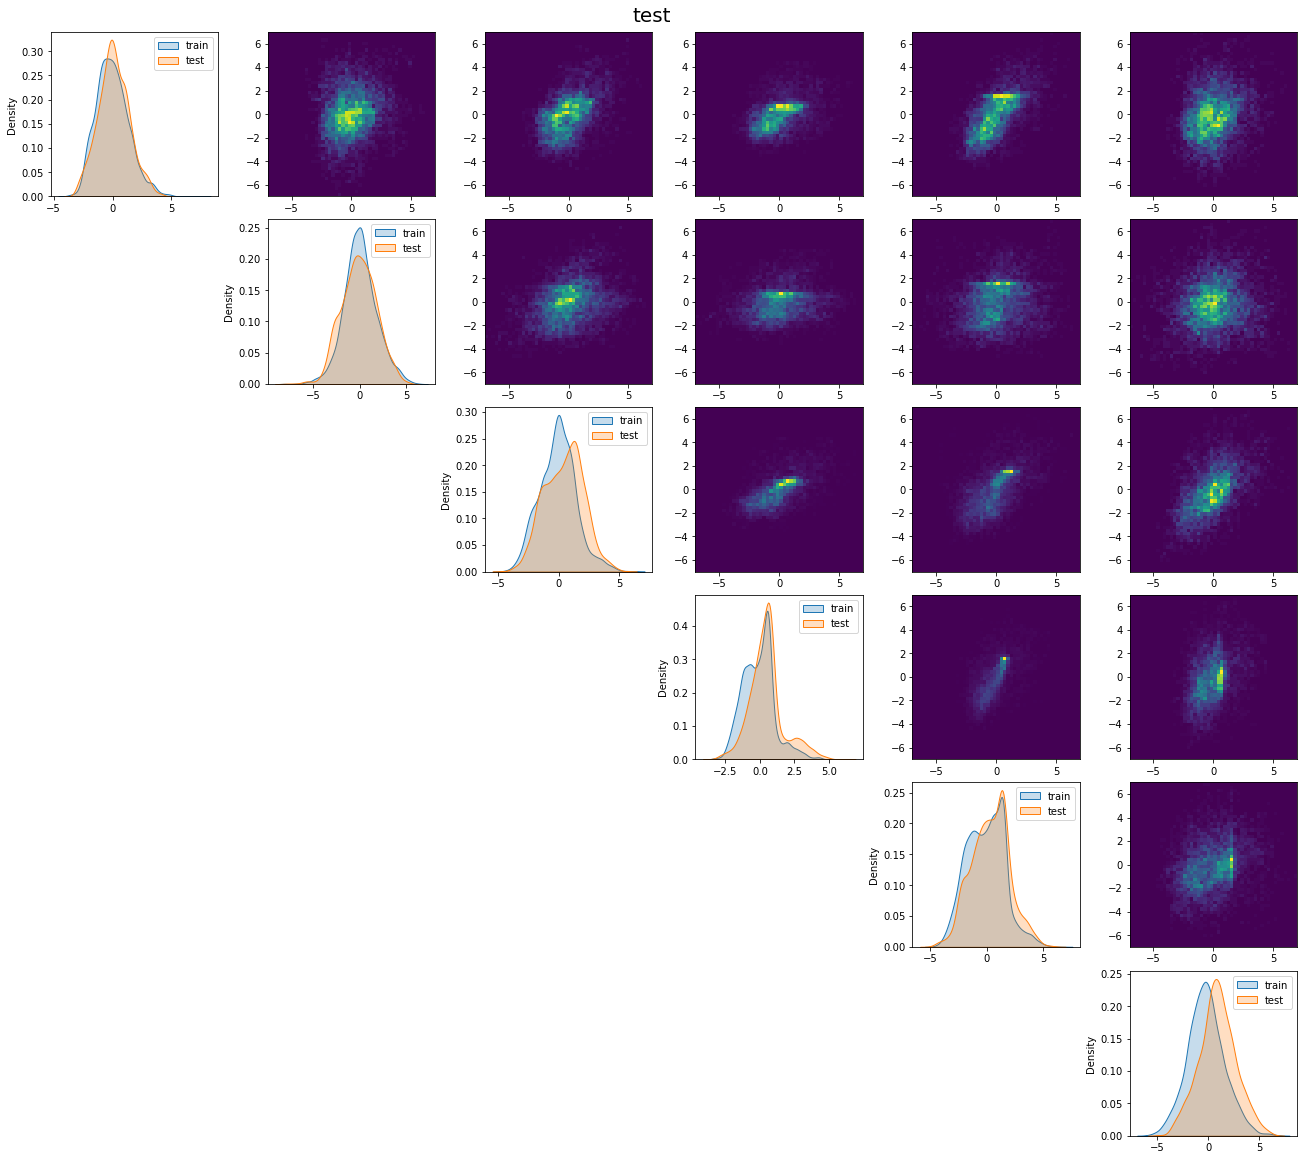

In [22]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18, 16), constrained_layout=True)
fig.suptitle('test', fontsize=20)

for i in range(6):
    for j in range(6):
        if i < j:
            ax[i][j].hist2d(df_train[f's{i+1}'], df_train[f's{j+1}'], bins=50, range=[[-7, 7], [-7, 7]])
        if i > j:
            fig.delaxes(ax[i][j])
    sns.kdeplot(data=df_train.to_numpy()[:, i], ax=ax[i][i], fill=True, label='train')
    sns.kdeplot(data=df_test.to_numpy()[:, i], ax=ax[i][i], fill=True, label='test')
    ax[i][i].legend()


# Train

In [ ]:
with open('configs/maf.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

class HistCallback(Callback):
    def on_validation_start(self, trainer, pl_module):
        
        X_val = trainer.datamodule.val_dataset[:][0]
        X_val_pred = trainer.model.model.sample(torch.randn((len(X_val), trainer.model.model.n_latent_dim)))
        fig = plot_hist2d(X_val_pred, X_val)
                
        clear_output(wait=True)
        plt.show()

        if hasattr(trainer.model.model, 'weights'):
            date_range = pd.date_range(trainer.datamodule.train_start_date, trainer.datamodule.train_end_date, freq='M')
            weights = trainer.model.model.weights(torch.linspace(0, 1, len(date_range))[:, None]).detach().numpy()
            plt.plot(date_range, weights)
            
        print(f"Epoch: {trainer.current_epoch+1}/{trainer.max_epochs}")

with mlflow.start_run() as active_run:
    run(config, enable_progress_bar=True, callbacks=[HistCallback()])